In [ ]:
!pip install statsmodels

In [ ]:
#!pip install xeus-python

In [126]:
!pip install deap

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.5/135.5 kB 4.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
from IPython.core.debugger import Pdb

In [1]:
import sys
sys.path.append("/ibkr")

import os
import datetime
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import coint
import itertools

import tensorflow as tf
from tensorflow.keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import pytz

import backtrader as bt
import statsmodels.api as sm

import passwords
from databaseClass import DB
from utils import generate_df_from_sql_file, generate_list_from_sql_file
from utils import DataProcessor
from utils import ModelBuilder
from utils import Predictor
pd.set_option('display.max_columns', None)

2023-08-16 03:18:51.280869: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-16 03:18:51.301895: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
userName = passwords.userName
userPass = passwords.userPass
dataBaseName = passwords.dataBaseName
host = passwords.host

In [3]:
db = DB(userName=userName, userPass=userPass, dataBaseName=dataBaseName, host='ibkr_db', docker=True)

In [39]:
df = db.DBtoDF("SELECT * FROM pairs")
#dates_to_drop = ['2022-08-08', '2022-08-09', '2023-08-08', '2023-08-09']  # Replace with the actual dates you want to drop
df = df[~df['date'].isin(dates_to_drop)]  # This will remove rows with specified dates
df.set_index('date', inplace=True)


# # 2. Extract SPY data and calculate returns
# spy_df = df[df['ticker'] == 'SPY']
# spy_df = spy_df.sort_values(by='date')  # Ensure data is sorted by date
# spy_df['daily_return'] = spy_df['close'].pct_change()  # Compute daily returns
# spy_returns = spy_df['daily_return'].tolist()[1:]  # Convert to list and exclude the first NaN value

# # 3. Remove SPY from the original dataframe
# df = df[df['ticker'] != 'SPY']

/ibkr/databaseClass.py:111: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, con=conn)


In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 502575 entries, 2023-01-17 to 2023-01-13
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ticker  502575 non-null  object 
 1   open    502575 non-null  float64
 2   high    502575 non-null  float64
 3   low     502575 non-null  float64
 4   close   502575 non-null  float64
 5   volume  502575 non-null  int64  
 6   count   502575 non-null  int64  
 7   wap     502575 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 34.5+ MB


In [197]:
def build_pairs(df, correlation_threshold, coint_p_value_threshold):

#     df = df.set_index('date')

    # Reshape the dataframe so that each column is a ticker's close prices
    df_close = df.pivot(columns='ticker', values='close')

    # Calculate the correlation matrix
    corr_matrix = df_close.corr()

    # Find pairs of tickers where correlation is above correlation_threshold
    correlated_pairs = []
    for i in range(corr_matrix.shape[0]):
        for j in range(i+1, corr_matrix.shape[1]):
            if corr_matrix.iloc[i, j] > correlation_threshold:
                correlated_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))    
    
    # Apply the cointegration test to these pairs
    cointegrated_pairs = []
    for pair in correlated_pairs:
        if df_close[pair[0]].isnull().any() or df_close[pair[1]].isnull().any() or np.isinf(df_close[pair[0]]).any() or np.isinf(df_close[pair[1]]).any():
            #print(df_close[pair[0]])
            #print("DataFrame contains NaN or inf values.")
            continue
        score, pvalue, _ = coint(df_close[pair[0]], df_close[pair[1]])
        if pvalue < coint_p_value_threshold:
            cointegrated_pairs.append((pair[0], pair[1], pvalue))
            
    # Sort the cointegrated pairs by their p-value in ascending order
    cointegrated_pairs.sort(key=lambda x: x[2])

    return correlated_pairs, cointegrated_pairs

In [8]:
correlated_pairs, cointegrated_pairs = build_pairs(df, .98, .01)

In [198]:
correlated_pairs_hourly, cointegrated_pairs_hourly = build_pairs(df_hourly, .25, .95)

In [199]:
correlated_pairs_hourly

[('CAC', 'CIVB', 0.7090054762801897),
 ('CAC', 'CNOB', 0.9424979719220428),
 ('CAC', 'DCOM', 0.9010094348850395),
 ('CAC', 'FFIC', 0.9535727411715952),
 ('CAC', 'FISI', 0.9177570263431262),
 ('CAC', 'FLIC', 0.959154785892971),
 ('CAC', 'FRME', 0.7798852750348219),
 ('CAC', 'FRST', 0.8982703524075324),
 ('CAC', 'IBTX', 0.9078334892063529),
 ('CAC', 'JOAN', 0.7482677154208448),
 ('CAC', 'KBH', 0.4532778479879653),
 ('CAC', 'LBAI', 0.6371521472504695),
 ('CAC', 'MDC', 0.7056869910366607),
 ('CAC', 'MHO', 0.7787046600818712),
 ('CAC', 'MNTS', 0.6260323190197927),
 ('CAC', 'MTH', 0.5349499193989159),
 ('CAC', 'MYFW', 0.8408346134201544),
 ('CAC', 'NWBI', 0.8206059932275832),
 ('CAC', 'OCFC', 0.8280198955981573),
 ('CAC', 'PHM', 0.7037098080685732),
 ('CAC', 'PPBI', 0.8540861820898287),
 ('CAC', 'RBB', 0.8530531810153118),
 ('CAC', 'SFST', 0.9094755713183046),
 ('CAC', 'TCBK', 0.8000783349360588),
 ('CAC', 'THFF', 0.8943255567997888),
 ('CAC', 'TMP', 0.41508676658365745),
 ('CAC', 'WSBC', 0.

In [132]:
len(cointegrated_pairs)

26

In [206]:
cointegrated_pairs

[('DCOM', 'NWBI', 6.931876734139303e-06),
 ('FRME', 'NWBI', 9.37938259373182e-05),
 ('TCMD', 'TPH', 0.00013073334263829345),
 ('CCS', 'LEN', 0.0006196557061908078),
 ('CAC', 'FRST', 0.0008485027070045955),
 ('LBAI', 'OCFC', 0.000903611374429789),
 ('CCS', 'MTH', 0.0009796528086234786),
 ('CAC', 'IBTX', 0.0010073871417657944),
 ('DCOM', 'SFST', 0.0011273781403298882),
 ('KBH', 'PHM', 0.0011802965098307982),
 ('NWBI', 'THFF', 0.0012415205030575284),
 ('FRST', 'IBTX', 0.001941843898475266),
 ('DCOM', 'FRME', 0.0022399937984697534),
 ('JOAN', 'MNTS', 0.002264131645384891),
 ('TMP', 'WSBC', 0.002372145409391496),
 ('NWBI', 'PPBI', 0.0024458720041988205),
 ('DCOM', 'RBB', 0.003658108066248698),
 ('MDC', 'PHM', 0.003958810756435488),
 ('FISI', 'IBTX', 0.0052866348855049065),
 ('MDC', 'MHO', 0.006825166993485608),
 ('LEN', 'TMHC', 0.008255969753706589),
 ('FFIC', 'FLIC', 0.008496965029977478),
 ('CIVB', 'MYFW', 0.00883506396397999),
 ('CNOB', 'FLIC', 0.009295107676352634),
 ('TCBK', 'WSBC', 0.

In [194]:
#len(correlated_pairs_hourly)
len(cointegrated_pairs_hourly)

0

In [137]:
ticker_list = []
for pair in cointegrated_pairs:
    ticker_list.append(pair[0])
    ticker_list.append(pair[1])

In [140]:
ticker_list[0:4]

['DCOM', 'NWBI', 'FRME', 'NWBI']

In [10]:
cointegrated_pairs[0]

('DCOM', 'NWBI', 6.931876734139303e-06)

In [200]:
def plot_pair(df, ticker1, ticker2, plot_type='price'):
    '''
    plot_type can be: 'price', 'cumulative_returns', or 'daily_returns'
    '''
    #df = df.set_index('date')
    df_close = df.pivot(columns='ticker', values='close')

    if plot_type == 'cumulative_returns':
        df_close = ((df_close.pct_change() + 1).cumprod() - 1).dropna()
    elif plot_type == 'daily_returns':
        df_close = df_close.pct_change().dropna()

    plt.figure(figsize=(20,10))
    plt.plot(df_close[ticker1], label=ticker1)
    plt.plot(df_close[ticker2], label=ticker2)
    plt.title(f'{plot_type.title()} of {ticker1} and {ticker2}')
    plt.xlabel('Date')

    if plot_type == 'cumulative_returns':
        plt.ylabel('Cumulative Returns')
    elif plot_type == 'daily_returns':
        plt.ylabel('Daily Returns')
    else:
        plt.ylabel('Closing Price')

    plt.legend()
    plt.show()

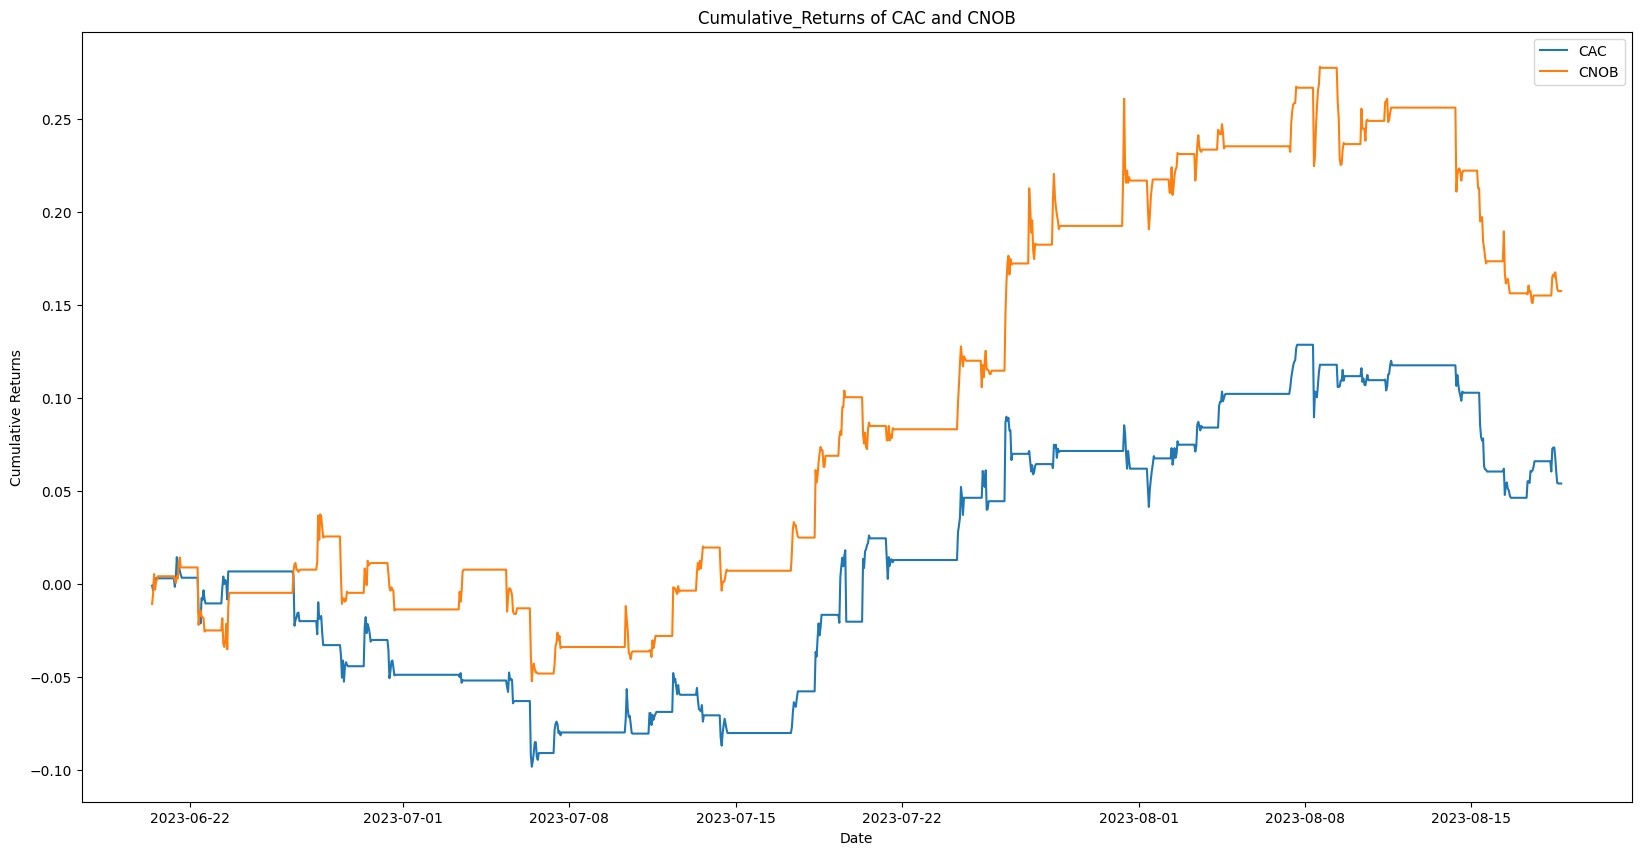

In [204]:
#plot_pair(df, cointegrated_pairs[0][0], cointegrated_pairs[0][1], 'cumulative_returns')
plot_pair(df_hourly, 'CAC', 'CNOB', 'cumulative_returns')

In [ ]:
closing_prices = df.pivot(columns='ticker', values='close')

In [ ]:
df.head()

In [ ]:
#this naive approach works.  I'm going to implement changes

def plot_strategy(df_combined):
    # 3. Plotting Returns:
    plt.figure(figsize=(14,7))
    df_combined['portfolio_value'].plot(label='Pairs Trading Strategy')
    df_combined['SPY_portfolio_value'].plot(label='SPY Returns')
    plt.legend()
    plt.title('Pairs Trading Strategy vs SPY Returns')
    plt.show()
    
    
def evaluate_pairs(df_combined):
    # Prepare data for regression
    X = df_combined['SPY_returns']
    X = sm.add_constant(X)  # Adds a constant (intercept) to the model
    y = df_combined['portfolio_value'].pct_change().fillna(0)

    # Regression model
    model = sm.OLS(y, X).fit()

    alpha = model.params[0]
    beta = model.params[1]

    # 5. Calculate Sharpe Ratio:
    risk_free_rate = 0.01  # Approximated risk-free rate, adjust as needed
    strategy_excess_return = df_combined['portfolio_value'].pct_change().mean() - risk_free_rate
    strategy_std = df_combined['portfolio_value'].pct_change().std()
    sharpe_ratio = strategy_excess_return / strategy_std
    return {
        "alpha": alpha,
        "beta": beta,
        "sharpe_ratio": sharpe_ratio
    }


# Define pair
stock1 = 'DCOM'
stock2 = 'NWBI'
lookback = 20
df_combined = 0

# Filter for pairs data
df_stock1 = df[df['ticker'] == stock1].copy()
df_stock2 = df[df['ticker'] == stock2].copy()
df_SPY = df[df['ticker'] == 'SPY'].copy()


df_stock1 = df_stock1.add_suffix('_stock1')
df_stock2 = df_stock2.add_suffix('_stock2')
df_SPY = df_SPY.add_suffix('_SPY')
df_combined = df_stock1.merge(df_stock2, left_index=True, right_index=True)

df_combined['spread'] = df_combined['close_stock1'] - df_combined['close_stock2']

# Calculate mean and std deviation
df_combined['rolling_mean'] = df_combined['spread'].rolling(window=lookback).mean()
df_combined['rolling_std'] = df_combined['spread'].rolling(window=lookback).std()

# Decide Buy/Sell signals
threshold = 1  # e.g., 1 std deviation
df_combined['signal'] = 'Do Nothing'
df_combined.loc[df_combined['spread'] > df_combined['rolling_mean'] + threshold * df_combined['rolling_std'], 'signal'] = 'Sell Stock1, Buy Stock2'
df_combined.loc[df_combined['spread'] < df_combined['rolling_mean'] - threshold * df_combined['rolling_std'], 'signal'] = 'Buy Stock1, Sell Stock2'


# Update portfolio calculations using df_combined
initial_investment = 100000
total_cash = initial_investment
stock1_qty_cumulative = 0
stock2_qty_cumulative = 0

# Initialize portfolio and quantities columns
df_combined['portfolio_value'] = np.nan
df_combined['stock1_qty'] = np.nan
df_combined['stock2_qty'] = np.nan
df_combined['total_cash'] = np.nan
df_combined['stock1_value'] = np.nan
df_combined['stock2_value'] = np.nan


for i, row in df_combined.iterrows():
    # Cash from selling current positions:
    cash_from_stock1 = stock1_qty_cumulative * row['close_stock1']
    cash_from_stock2 = stock2_qty_cumulative * row['close_stock2']
    
    total_cash += cash_from_stock1 + cash_from_stock2
    stock1_qty_cumulative = 0  # Resetting the stock quantities as we've 'sold' them.
    stock2_qty_cumulative = 0

    # Now, based on the signal, we make new purchases:
    if row['signal'] == 'Buy Stock1, Sell Stock2':
        stock1_qty = total_cash / 2 / row['close_stock1']
        stock2_qty = -total_cash / 2 / row['close_stock2']
    elif row['signal'] == 'Sell Stock1, Buy Stock2':
        stock1_qty = -total_cash / 2 / row['close_stock1']
        stock2_qty = total_cash / 2 / row['close_stock2']
    else:  # 'Do Nothing'
        stock1_qty = 0
        stock2_qty = 0

    cash_spent_on_stock1 = stock1_qty * row['close_stock1']
    cash_spent_on_stock2 = stock2_qty * row['close_stock2']
    
    # Update total cash after purchases:
    total_cash -= cash_spent_on_stock1
    total_cash -= cash_spent_on_stock2

    stock1_qty_cumulative += stock1_qty
    stock2_qty_cumulative += stock2_qty

    stock1_value = stock1_qty_cumulative * row['close_stock1']
    stock2_value = stock2_qty_cumulative * row['close_stock2']
    portfolio_value = stock1_value + stock2_value + total_cash

    df_combined.at[i, 'total_cash'] = total_cash
    df_combined.at[i, 'stock1_value'] = stock1_value
    df_combined.at[i, 'stock2_value'] = stock2_value
    df_combined.at[i, 'portfolio_value'] = portfolio_value
    df_combined.at[i, 'stock1_qty'] = stock1_qty_cumulative
    df_combined.at[i, 'stock2_qty'] = stock2_qty_cumulative


# 2. Calculate SPY Portfolio Value:
df_combined = df_combined.join(df_SPY, how='left')
# initial_investment = df_combined['portfolio_value'].iloc[0]
df_combined['SPY_returns'] = df_combined['close_SPY'].pct_change().fillna(0)
df_combined['SPY_cumulative_returns'] = (1 + df_combined['SPY_returns']).cumprod()
df_combined['SPY_portfolio_value'] = df_combined['SPY_cumulative_returns'] * initial_investment

plot_strategy(df_combined)
evaluate_pairs(df_combined)

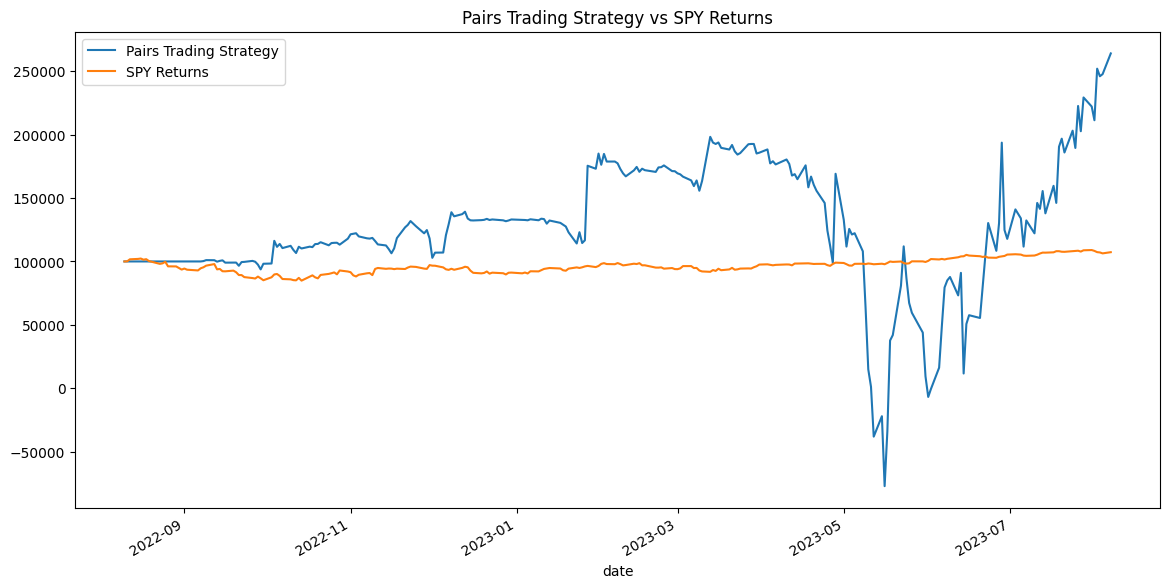

{'alpha': -0.26658898067182807,
 'beta': 7.151073605108502,
 'sharpe_ratio': -0.08893819176448065}

In [28]:
#this naive approach works.  I'm going to implement changes. This includes changes to daily portfolio_value

def plot_strategy(df_combined):
    # 3. Plotting Returns:
    plt.figure(figsize=(14,7))
    df_combined['portfolio_value'].plot(label='Pairs Trading Strategy')
    df_combined['SPY_portfolio_value'].plot(label='SPY Returns')
    plt.legend()
    plt.title('Pairs Trading Strategy vs SPY Returns')
    plt.show()
    
    
def evaluate_pairs(df_combined):
    # Prepare data for regression
    X = df_combined['SPY_returns']
    X = sm.add_constant(X)  # Adds a constant (intercept) to the model
    y = df_combined['portfolio_value'].pct_change().fillna(0)

    # Regression model
    model = sm.OLS(y, X).fit()

    alpha = model.params[0]
    beta = model.params[1]

    # 5. Calculate Sharpe Ratio:
    risk_free_rate = 0.01  # Approximated risk-free rate, adjust as needed
    strategy_excess_return = df_combined['portfolio_value'].pct_change().mean() - risk_free_rate
    strategy_std = df_combined['portfolio_value'].pct_change().std()
    sharpe_ratio = strategy_excess_return / strategy_std
    return {
        "alpha": alpha,
        "beta": beta,
        "sharpe_ratio": sharpe_ratio
    }


# Define pair
stock1 = 'DCOM'
stock2 = 'NWBI'
lookback = 20
df_combined = 0

# Filter for pairs data
df_stock1 = df[df['ticker'] == stock1].copy()
df_stock2 = df[df['ticker'] == stock2].copy()
df_SPY = df[df['ticker'] == 'SPY'].copy()


df_stock1 = df_stock1.add_suffix('_stock1')
df_stock2 = df_stock2.add_suffix('_stock2')
df_SPY = df_SPY.add_suffix('_SPY')
df_combined = df_stock1.merge(df_stock2, left_index=True, right_index=True)

df_combined['spread'] = df_combined['close_stock1'] - df_combined['close_stock2']

# Calculate mean and std deviation
df_combined['rolling_mean'] = df_combined['spread'].rolling(window=lookback).mean()
df_combined['rolling_std'] = df_combined['spread'].rolling(window=lookback).std()

# Decide Buy/Sell signals
threshold = 1  # e.g., 1 std deviation
df_combined['signal'] = 'Do Nothing'
df_combined.loc[df_combined['spread'] > df_combined['rolling_mean'] + threshold * df_combined['rolling_std'], 'signal'] = 'Sell Stock1, Buy Stock2'
df_combined.loc[df_combined['spread'] < df_combined['rolling_mean'] - threshold * df_combined['rolling_std'], 'signal'] = 'Buy Stock1, Sell Stock2'


# Update portfolio calculations using df_combined
initial_investment = 100000
total_cash = initial_investment
stock1_qty_cumulative = 0
stock2_qty_cumulative = 0

# Initialize portfolio and quantities columns
df_combined['portfolio_value'] = np.nan
df_combined['stock1_qty'] = np.nan
df_combined['stock2_qty'] = np.nan
df_combined['total_cash'] = np.nan
df_combined['stock1_value'] = np.nan
df_combined['stock2_value'] = np.nan


for i, row in df_combined.iterrows():

    # Values for stocks based on current holdings:
    stock1_value = stock1_qty_cumulative * row['close_stock1']
    stock2_value = stock2_qty_cumulative * row['close_stock2']
    portfolio_value_before_trade = stock1_value + stock2_value + total_cash

    # Now, based on the signal, we decide to make new trades or not:
    if row['signal'] == 'Buy Stock1, Sell Stock2':
        stock1_qty = total_cash / 2 / row['close_stock1']
        stock2_qty = -total_cash / 2 / row['close_stock2']
    elif row['signal'] == 'Sell Stock1, Buy Stock2':
        stock1_qty = -total_cash / 2 / row['close_stock1']
        stock2_qty = total_cash / 2 / row['close_stock2']
    else:  # 'Do Nothing'
        stock1_qty = 0
        stock2_qty = 0

    cash_spent_on_stock1 = stock1_qty * row['close_stock1']
    cash_spent_on_stock2 = stock2_qty * row['close_stock2']

    # Update total cash after purchases:
    total_cash -= cash_spent_on_stock1
    total_cash -= cash_spent_on_stock2

    stock1_qty_cumulative += stock1_qty
    stock2_qty_cumulative += stock2_qty

    # Update portfolio value after the trade:
    stock1_value = stock1_qty_cumulative * row['close_stock1']
    stock2_value = stock2_qty_cumulative * row['close_stock2']
    portfolio_value = stock1_value + stock2_value + total_cash

    df_combined.at[i, 'total_cash'] = total_cash
    df_combined.at[i, 'stock1_value'] = stock1_value
    df_combined.at[i, 'stock2_value'] = stock2_value
    df_combined.at[i, 'portfolio_value'] = portfolio_value
    df_combined.at[i, 'stock1_qty'] = stock1_qty_cumulative
    df_combined.at[i, 'stock2_qty'] = stock2_qty_cumulative



# 2. Calculate SPY Portfolio Value:
df_combined = df_combined.join(df_SPY, how='left')
# initial_investment = df_combined['portfolio_value'].iloc[0]
df_combined['SPY_returns'] = df_combined['close_SPY'].pct_change().fillna(0)
df_combined['SPY_cumulative_returns'] = (1 + df_combined['SPY_returns']).cumprod()
df_combined['SPY_portfolio_value'] = df_combined['SPY_cumulative_returns'] * initial_investment

plot_strategy(df_combined)
evaluate_pairs(df_combined)

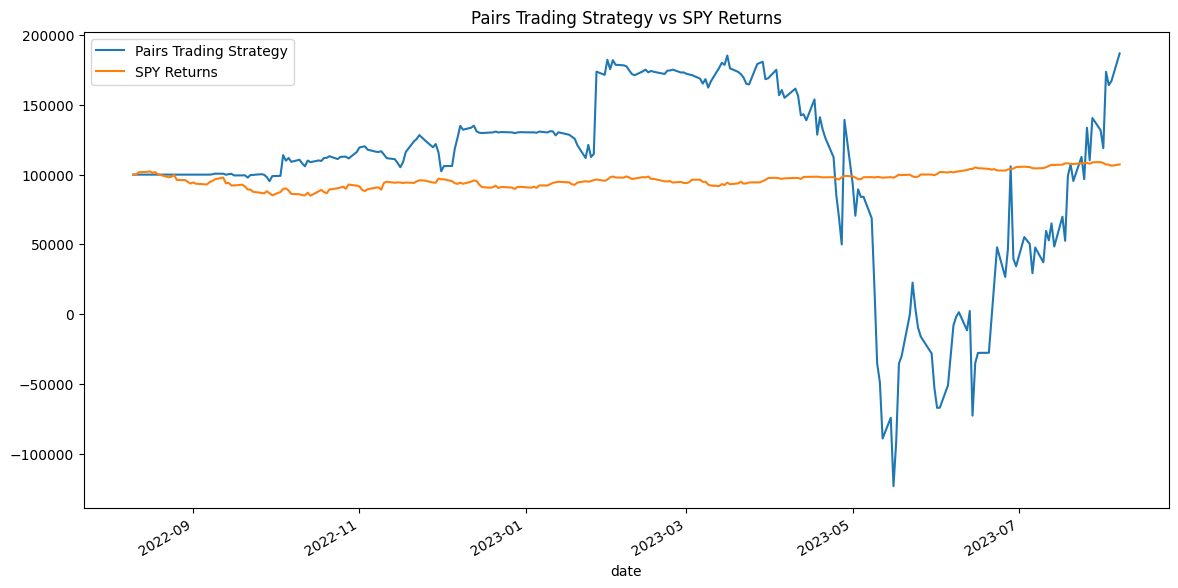

{'alpha': -0.5506014038520429,
 'beta': 22.399715655371327,
 'sharpe_ratio': -0.10549169905542624,
 'total_return': 86.88007839198437}

In [31]:
#this includes dynamic allocations.  next to change is stop-loss or take profit

def plot_strategy(df_combined):
    # 3. Plotting Returns:
    plt.figure(figsize=(14,7))
    df_combined['portfolio_value'].plot(label='Pairs Trading Strategy')
    df_combined['SPY_portfolio_value'].plot(label='SPY Returns')
    plt.legend()
    plt.title('Pairs Trading Strategy vs SPY Returns')
    plt.show()
    
    
def evaluate_pairs(df_combined):
    # Prepare data for regression
    X = df_combined['SPY_returns']
    X = sm.add_constant(X)  # Adds a constant (intercept) to the model
    y = df_combined['portfolio_value'].pct_change().fillna(0)

    # Regression model
    model = sm.OLS(y, X).fit()

    alpha = model.params[0]
    beta = model.params[1]

    # 5. Calculate Sharpe Ratio:
    risk_free_rate = 0.01  # Approximated risk-free rate, adjust as needed
    strategy_excess_return = df_combined['portfolio_value'].pct_change().mean() - risk_free_rate
    strategy_std = df_combined['portfolio_value'].pct_change().std()
    sharpe_ratio = strategy_excess_return / strategy_std
    # Calculate total return
    initial_investment = df_combined['portfolio_value'].iloc[0]
    final_portfolio_value = df_combined['portfolio_value'].iloc[-1]
    total_return = (final_portfolio_value / initial_investment - 1) * 100  # in percentage

    return {
        "alpha": alpha,
        "beta": beta,
        "sharpe_ratio": sharpe_ratio,
        "total_return": total_return
    }


# Define pair
stock1 = 'DCOM'
stock2 = 'NWBI'
lookback = 20
df_combined = 0

# Filter for pairs data
df_stock1 = df[df['ticker'] == stock1].copy()
df_stock2 = df[df['ticker'] == stock2].copy()
df_SPY = df[df['ticker'] == 'SPY'].copy()


df_stock1 = df_stock1.add_suffix('_stock1')
df_stock2 = df_stock2.add_suffix('_stock2')
df_SPY = df_SPY.add_suffix('_SPY')
df_combined = df_stock1.merge(df_stock2, left_index=True, right_index=True)

df_combined['spread'] = df_combined['close_stock1'] - df_combined['close_stock2']

# Calculate mean and std deviation
df_combined['rolling_mean'] = df_combined['spread'].rolling(window=lookback).mean()
df_combined['rolling_std'] = df_combined['spread'].rolling(window=lookback).std()

# Decide Buy/Sell signals
threshold = 1  # e.g., 1 std deviation
df_combined['signal'] = 'Do Nothing'
df_combined.loc[df_combined['spread'] > df_combined['rolling_mean'] + threshold * df_combined['rolling_std'], 'signal'] = 'Sell Stock1, Buy Stock2'
df_combined.loc[df_combined['spread'] < df_combined['rolling_mean'] - threshold * df_combined['rolling_std'], 'signal'] = 'Buy Stock1, Sell Stock2'


# Update portfolio calculations using df_combined
initial_investment = 100000
total_cash = initial_investment
stock1_qty_cumulative = 0
stock2_qty_cumulative = 0

# Initialize portfolio and quantities columns
df_combined['portfolio_value'] = np.nan
df_combined['stock1_qty'] = np.nan
df_combined['stock2_qty'] = np.nan
df_combined['total_cash'] = np.nan
df_combined['stock1_value'] = np.nan
df_combined['stock2_value'] = np.nan

df_combined['z_score'] = (df_combined['spread'] - df_combined['rolling_mean']) / df_combined['rolling_std']

# Percentage of portfolio value to use for base trading (e.g., 50%)
trade_percentage = 0.50
# Maximum multiple of base trade size to consider (e.g., 2 or 200%)
max_multiplier = 2.0

for i, row in df_combined.iterrows():

    # Values for stocks based on current holdings:
    stock1_value = stock1_qty_cumulative * row['close_stock1']
    stock2_value = stock2_qty_cumulative * row['close_stock2']
    portfolio_value_before_trade = stock1_value + stock2_value + total_cash


    # Calculate adaptive trade size based on z-score
    base_trade_size = portfolio_value * trade_percentage
    adaptive_trade_size = base_trade_size * min(abs(row['z_score']), max_multiplier)

    # Now, based on the signal, we decide to make new trades or not:

    if row['signal'] == 'Buy Stock1, Sell Stock2':
        stock1_qty = adaptive_trade_size / 2 / row['close_stock1']
        stock2_qty = -adaptive_trade_size / 2 / row['close_stock2']
    elif row['signal'] == 'Sell Stock1, Buy Stock2':
        stock1_qty = -adaptive_trade_size / 2 / row['close_stock1']
        stock2_qty = adaptive_trade_size / 2 / row['close_stock2']
    else:  # 'Do Nothing'
        stock1_qty = 0
        stock2_qty = 0

    cash_spent_on_stock1 = stock1_qty * row['close_stock1']
    cash_spent_on_stock2 = stock2_qty * row['close_stock2']

    # Update total cash after purchases:
    total_cash -= cash_spent_on_stock1
    total_cash -= cash_spent_on_stock2

    stock1_qty_cumulative += stock1_qty
    stock2_qty_cumulative += stock2_qty

    # Update portfolio value after the trade:
    stock1_value = stock1_qty_cumulative * row['close_stock1']
    stock2_value = stock2_qty_cumulative * row['close_stock2']
    portfolio_value = stock1_value + stock2_value + total_cash

    df_combined.at[i, 'total_cash'] = total_cash
    df_combined.at[i, 'stock1_value'] = stock1_value
    df_combined.at[i, 'stock2_value'] = stock2_value
    df_combined.at[i, 'portfolio_value'] = portfolio_value
    df_combined.at[i, 'stock1_qty'] = stock1_qty_cumulative
    df_combined.at[i, 'stock2_qty'] = stock2_qty_cumulative


# 2. Calculate SPY Portfolio Value:
df_combined = df_combined.join(df_SPY, how='left')
# initial_investment = df_combined['portfolio_value'].iloc[0]
df_combined['SPY_returns'] = df_combined['close_SPY'].pct_change().fillna(0)
df_combined['SPY_cumulative_returns'] = (1 + df_combined['SPY_returns']).cumprod()
df_combined['SPY_portfolio_value'] = df_combined['SPY_cumulative_returns'] * initial_investment

plot_strategy(df_combined)
evaluate_pairs(df_combined)

In [32]:
df_combined.to_csv("df_combined_olderstrategy.csv")

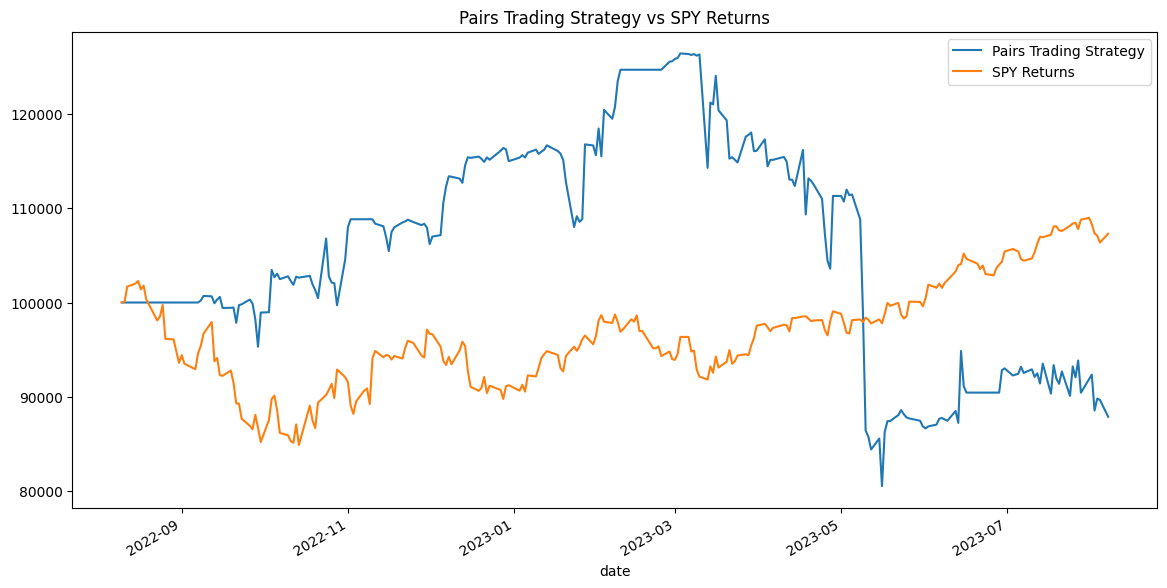

{'alpha': -0.00030136467102088787,
 'beta': 0.053127183018707114,
 'sharpe_ratio': -0.47389860346305707,
 'total_return': -12.125386307562058}

In [42]:
# This includes stop loss and take profit

def plot_strategy(df_combined):
    # 3. Plotting Returns:
    plt.figure(figsize=(14,7))
    df_combined['portfolio_value'].plot(label='Pairs Trading Strategy')
    df_combined['SPY_portfolio_value'].plot(label='SPY Returns')
    plt.legend()
    plt.title('Pairs Trading Strategy vs SPY Returns')
    plt.show()
    
    
def evaluate_pairs(df_combined):
    # Prepare data for regression
    X = df_combined['SPY_returns']
    X = sm.add_constant(X)  # Adds a constant (intercept) to the model
    y = df_combined['portfolio_value'].pct_change().fillna(0)

    # Regression model
    model = sm.OLS(y, X).fit()

    alpha = model.params[0]
    beta = model.params[1]

    # 5. Calculate Sharpe Ratio:
    risk_free_rate = 0.01  # Approximated risk-free rate, adjust as needed
    strategy_excess_return = df_combined['portfolio_value'].pct_change().mean() - risk_free_rate
    strategy_std = df_combined['portfolio_value'].pct_change().std()
    sharpe_ratio = strategy_excess_return / strategy_std
    # Calculate total return
    initial_investment = df_combined['portfolio_value'].iloc[0]
    final_portfolio_value = df_combined['portfolio_value'].iloc[-1]
    total_return = (final_portfolio_value / initial_investment - 1) * 100  # in percentage

    return {
        "alpha": alpha,
        "beta": beta,
        "sharpe_ratio": sharpe_ratio,
        "total_return": total_return
    }


# Define pair
stock1 = 'DCOM'
stock2 = 'NWBI'
lookback = 20
df_combined = 0

# Filter for pairs data
df_stock1 = df[df['ticker'] == stock1].copy()
df_stock2 = df[df['ticker'] == stock2].copy()
df_SPY = df[df['ticker'] == 'SPY'].copy()


df_stock1 = df_stock1.add_suffix('_stock1')
df_stock2 = df_stock2.add_suffix('_stock2')
df_SPY = df_SPY.add_suffix('_SPY')
df_combined = df_stock1.merge(df_stock2, left_index=True, right_index=True)

df_combined['spread'] = df_combined['close_stock1'] - df_combined['close_stock2']

# Calculate mean and std deviation
df_combined['rolling_mean'] = df_combined['spread'].rolling(window=lookback).mean()
df_combined['rolling_std'] = df_combined['spread'].rolling(window=lookback).std()

# Decide Buy/Sell signals
threshold = 1  # e.g., 1 std deviation
df_combined['signal'] = 'Do Nothing'
df_combined.loc[df_combined['spread'] > df_combined['rolling_mean'] + threshold * df_combined['rolling_std'], 'signal'] = 'Sell Stock1, Buy Stock2'
df_combined.loc[df_combined['spread'] < df_combined['rolling_mean'] - threshold * df_combined['rolling_std'], 'signal'] = 'Buy Stock1, Sell Stock2'


# Update portfolio calculations using df_combined
initial_investment = 100000
total_cash = initial_investment
stock1_qty_cumulative = 0
stock2_qty_cumulative = 0

# Initialize portfolio and quantities columns
df_combined['portfolio_value'] = np.nan
df_combined['stock1_qty'] = np.nan
df_combined['stock2_qty'] = np.nan
df_combined['total_cash'] = np.nan
df_combined['stock1_value'] = np.nan
df_combined['stock2_value'] = np.nan
df_combined['risk_management'] = 'None'

df_combined['z_score'] = (df_combined['spread'] - df_combined['rolling_mean']) / df_combined['rolling_std']

# Percentage of portfolio value to use for base trading (e.g., 50%)
trade_percentage = 0.50
# Maximum multiple of base trade size to consider (e.g., 2 or 200%)
max_multiplier = 2.0

# Parameters for stop-loss and take-profit:
stop_loss_percentage = 0.03  # 3% stop loss
take_profit_percentage = 0.05  # 5% take profit

# Keeping track of peak portfolio value for stop loss:
peak_portfolio_value = initial_investment
entry_portfolio_value = initial_investment


for i, row in df_combined.iterrows():

    # Values for stocks based on current holdings:
    stock1_value = stock1_qty_cumulative * row['close_stock1']
    stock2_value = stock2_qty_cumulative * row['close_stock2']
    portfolio_value_before_trade = stock1_value + stock2_value + total_cash


    # Calculate adaptive trade size based on z-score
    base_trade_size = portfolio_value * trade_percentage
    adaptive_trade_size = base_trade_size * min(abs(row['z_score']), max_multiplier)

    # Now, based on the signal, we decide to make new trades or not:

    if row['signal'] == 'Buy Stock1, Sell Stock2':
        stock1_qty = adaptive_trade_size / 2 / row['close_stock1']
        stock2_qty = -adaptive_trade_size / 2 / row['close_stock2']
    elif row['signal'] == 'Sell Stock1, Buy Stock2':
        stock1_qty = -adaptive_trade_size / 2 / row['close_stock1']
        stock2_qty = adaptive_trade_size / 2 / row['close_stock2']
    else:  # 'Do Nothing'
        stock1_qty = 0
        stock2_qty = 0
        
    # Stop-loss logic
    if portfolio_value <= (1 - stop_loss_percentage) * peak_portfolio_value:
        # Close all positions
        df_combined.at[i, 'risk_management'] = 'Stop-loss'
        total_cash += stock1_qty_cumulative * row['close_stock1'] + stock2_qty_cumulative * row['close_stock2']
        stock1_qty_cumulative = 0
        stock2_qty_cumulative = 0
        # Reset the peak
        peak_portfolio_value = total_cash
        
    # Take-profit logic
    if i == 0:  # Assuming the first row as our "entry" into the strategy
        entry_portfolio_value = portfolio_value
    elif portfolio_value >= (1 + take_profit_percentage) * entry_portfolio_value:
        df_combined.at[i, 'risk_management'] = 'take-profit'
        # Close all positions
        total_cash += stock1_qty_cumulative * row['close_stock1'] + stock2_qty_cumulative * row['close_stock2']
        stock1_qty_cumulative = 0
        stock2_qty_cumulative = 0
        # Reset the entry value for the next round of trading
        entry_portfolio_value = total_cash   
    
    # Update the peak portfolio value if the current value is greater
    peak_portfolio_value = max(peak_portfolio_value, portfolio_value)
    

    cash_spent_on_stock1 = stock1_qty * row['close_stock1']
    cash_spent_on_stock2 = stock2_qty * row['close_stock2']

    # Update total cash after purchases:
    total_cash -= cash_spent_on_stock1
    total_cash -= cash_spent_on_stock2

    stock1_qty_cumulative += stock1_qty
    stock2_qty_cumulative += stock2_qty

    # Update portfolio value after the trade:
    stock1_value = stock1_qty_cumulative * row['close_stock1']
    stock2_value = stock2_qty_cumulative * row['close_stock2']
    portfolio_value = stock1_value + stock2_value + total_cash

    df_combined.at[i, 'total_cash'] = total_cash
    df_combined.at[i, 'stock1_value'] = stock1_value
    df_combined.at[i, 'stock2_value'] = stock2_value
    df_combined.at[i, 'portfolio_value'] = portfolio_value
    df_combined.at[i, 'stock1_qty'] = stock1_qty_cumulative
    df_combined.at[i, 'stock2_qty'] = stock2_qty_cumulative


# 2. Calculate SPY Portfolio Value:
df_combined = df_combined.join(df_SPY, how='left')
# initial_investment = df_combined['portfolio_value'].iloc[0]
df_combined['SPY_returns'] = df_combined['close_SPY'].pct_change().fillna(0)
df_combined['SPY_cumulative_returns'] = (1 + df_combined['SPY_returns']).cumprod()
df_combined['SPY_portfolio_value'] = df_combined['SPY_cumulative_returns'] * initial_investment

plot_strategy(df_combined)
evaluate_pairs(df_combined)

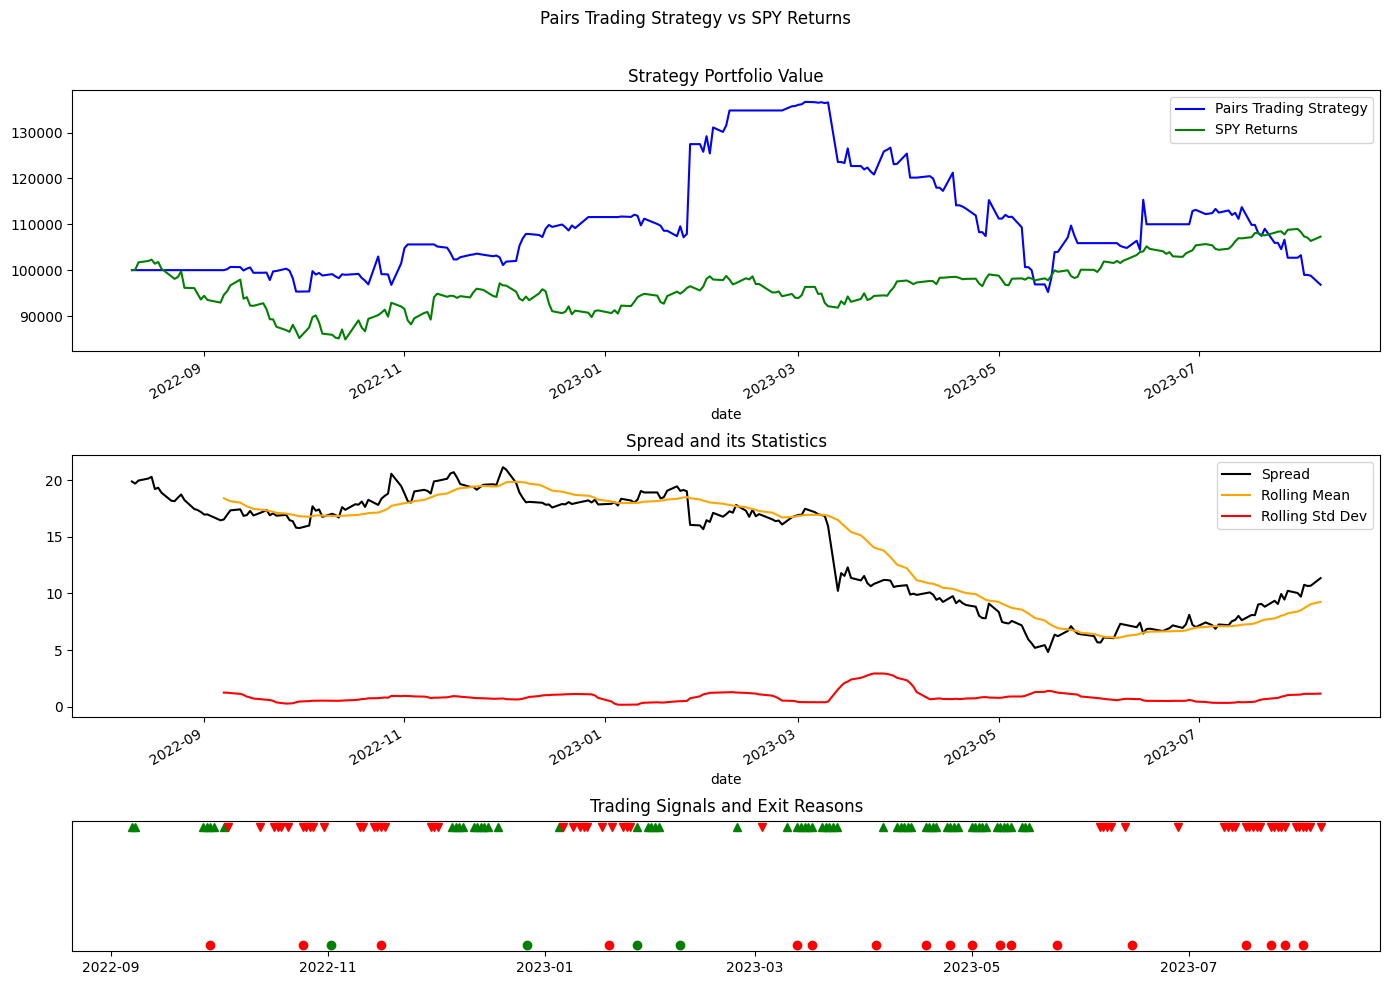

{'alpha': 7.639393019517643e-05,
 'beta': 0.08429515024536313,
 'sharpe_ratio': -0.44661936401038516,
 'total_return': -3.1838621615762563}

In [50]:
# This includes stop loss and take profit, and updated plotting.  This is last step before including a portfolio of pairs

def plot_strategy(df_combined):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [2, 2, 1]})
    fig.suptitle('Pairs Trading Strategy vs SPY Returns')

    # 1st subplot: Strategy Returns vs SPY Returns
    df_combined['portfolio_value'].plot(ax=ax1, label='Pairs Trading Strategy', color='blue')
    df_combined['SPY_portfolio_value'].plot(ax=ax1, label='SPY Returns', color='green')
    ax1.set_title('Strategy Portfolio Value')
    ax1.legend()

    # 2nd subplot: Spread, Rolling Mean, and Rolling Std Dev
    df_combined['spread'].plot(ax=ax2, label='Spread', color='black')
    df_combined['rolling_mean'].plot(ax=ax2, label='Rolling Mean', color='orange')
    df_combined['rolling_std'].plot(ax=ax2, label='Rolling Std Dev', color='red')
    ax2.set_title('Spread and its Statistics')
    ax2.legend()

    # 3rd subplot: Signals and Exit Reasons
    # We'll create markers for each of these signals.
    for i, row in df_combined.iterrows():
        if row['signal'] == 'Buy Stock1, Sell Stock2':
            ax3.plot(i, 1, 'g^')  # green triangle for this signal
        elif row['signal'] == 'Sell Stock1, Buy Stock2':
            ax3.plot(i, 1, 'rv')  # red triangle for this signal
        
        if row['exit_reason'] == 'Stop-loss':
            ax3.plot(i, 0, 'ro')  # red circle for stop-loss
        elif row['exit_reason'] == 'take-profit':
            ax3.plot(i, 0, 'go')  # green circle for take-profit
            
    ax3.set_title('Trading Signals and Exit Reasons')
    ax3.set_yticks([])
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()
    
    
def evaluate_pairs(df_combined):
    # Prepare data for regression
    X = df_combined['SPY_returns']
    X = sm.add_constant(X)  # Adds a constant (intercept) to the model
    y = df_combined['portfolio_value'].pct_change().fillna(0)

    # Regression model
    model = sm.OLS(y, X).fit()

    alpha = model.params[0]
    beta = model.params[1]

    # 5. Calculate Sharpe Ratio:
    risk_free_rate = 0.01  # Approximated risk-free rate, adjust as needed
    strategy_excess_return = df_combined['portfolio_value'].pct_change().mean() - risk_free_rate
    strategy_std = df_combined['portfolio_value'].pct_change().std()
    sharpe_ratio = strategy_excess_return / strategy_std
    # Calculate total return
    initial_investment = df_combined['portfolio_value'].iloc[0]
    final_portfolio_value = df_combined['portfolio_value'].iloc[-1]
    total_return = (final_portfolio_value / initial_investment - 1) * 100  # in percentage

    return {
        "alpha": alpha,
        "beta": beta,
        "sharpe_ratio": sharpe_ratio,
        "total_return": total_return
    }


# Define pair
stock1 = 'DCOM'
stock2 = 'NWBI'
lookback = 20
df_combined = 0

# Filter for pairs data
df_stock1 = df[df['ticker'] == stock1].copy()
df_stock2 = df[df['ticker'] == stock2].copy()
df_SPY = df[df['ticker'] == 'SPY'].copy()


df_stock1 = df_stock1.add_suffix('_stock1')
df_stock2 = df_stock2.add_suffix('_stock2')
df_SPY = df_SPY.add_suffix('_SPY')
df_combined = df_stock1.merge(df_stock2, left_index=True, right_index=True)

df_combined['spread'] = df_combined['close_stock1'] - df_combined['close_stock2']

# Calculate mean and std deviation
df_combined['rolling_mean'] = df_combined['spread'].rolling(window=lookback).mean()
df_combined['rolling_std'] = df_combined['spread'].rolling(window=lookback).std()

# Decide Buy/Sell signals
threshold = 1  # e.g., 1 std deviation
df_combined['signal'] = 'Do Nothing'
df_combined.loc[df_combined['spread'] > df_combined['rolling_mean'] + threshold * df_combined['rolling_std'], 'signal'] = 'Sell Stock1, Buy Stock2'
df_combined.loc[df_combined['spread'] < df_combined['rolling_mean'] - threshold * df_combined['rolling_std'], 'signal'] = 'Buy Stock1, Sell Stock2'


# Update portfolio calculations using df_combined
initial_investment = 100000
total_cash = initial_investment
stock1_qty_cumulative = 0
stock2_qty_cumulative = 0

# Initialize portfolio and quantities columns
df_combined['portfolio_value'] = np.nan
df_combined['stock1_qty'] = np.nan
df_combined['stock2_qty'] = np.nan
df_combined['total_cash'] = np.nan
df_combined['stock1_value'] = np.nan
df_combined['stock2_value'] = np.nan
df_combined['exit_reason'] = 'None'

df_combined['z_score'] = (df_combined['spread'] - df_combined['rolling_mean']) / df_combined['rolling_std']

# Percentage of portfolio value to use for base trading (e.g., 50%)
trade_percentage = 0.50
# Maximum multiple of base trade size to consider (e.g., 2 or 200%)
max_multiplier = 2.0

# Parameters for stop-loss and take-profit:
stop_loss_percentage = 0.03  # 3% stop loss
take_profit_percentage = 0.05  # 5% take profit

# Keeping track of peak portfolio value for stop loss:
peak_portfolio_value = initial_investment
entry_portfolio_value = initial_investment


for i, row in df_combined.iterrows():

    # Values for stocks based on current holdings:
    stock1_value = stock1_qty_cumulative * row['close_stock1']
    stock2_value = stock2_qty_cumulative * row['close_stock2']
    portfolio_value_before_trade = stock1_value + stock2_value + total_cash

    # Calculate adaptive trade size based on z-score
    base_trade_size = portfolio_value_before_trade * trade_percentage
    adaptive_trade_size = base_trade_size * min(abs(row['z_score']), max_multiplier)

    # Trading signals:
    if row['signal'] == 'Buy Stock1, Sell Stock2':
        stock1_qty = adaptive_trade_size / 2 / row['close_stock1']
        stock2_qty = -adaptive_trade_size / 2 / row['close_stock2']
    elif row['signal'] == 'Sell Stock1, Buy Stock2':
        stock1_qty = -adaptive_trade_size / 2 / row['close_stock1']
        stock2_qty = adaptive_trade_size / 2 / row['close_stock2']
    else:  # 'Do Nothing'
        stock1_qty = 0
        stock2_qty = 0

    # Stop-loss logic
    if portfolio_value_before_trade <= (1 - stop_loss_percentage) * peak_portfolio_value:
        df_combined.at[i, 'exit_reason'] = 'Stop-loss'
        total_cash += stock1_qty_cumulative * row['close_stock1'] + stock2_qty_cumulative * row['close_stock2']
        stock1_qty_cumulative = 0
        stock2_qty_cumulative = 0
        peak_portfolio_value = total_cash
        df_combined.at[i, 'total_cash'] = total_cash
        df_combined.at[i, 'stock1_value'] = 0  # because all positions are closed
        df_combined.at[i, 'stock2_value'] = 0
        df_combined.at[i, 'portfolio_value'] = total_cash
        df_combined.at[i, 'stock1_qty'] = 0
        df_combined.at[i, 'stock2_qty'] = 0
        continue

    # Take-profit logic
    elif i != 0 and portfolio_value_before_trade >= (1 + take_profit_percentage) * entry_portfolio_value:
        df_combined.at[i, 'exit_reason'] = 'take-profit'
        total_cash += stock1_qty_cumulative * row['close_stock1'] + stock2_qty_cumulative * row['close_stock2']
        stock1_qty_cumulative = 0
        stock2_qty_cumulative = 0
        entry_portfolio_value = total_cash
        df_combined.at[i, 'total_cash'] = total_cash
        df_combined.at[i, 'stock1_value'] = 0  # because all positions are closed
        df_combined.at[i, 'stock2_value'] = 0
        df_combined.at[i, 'portfolio_value'] = total_cash
        df_combined.at[i, 'stock1_qty'] = 0
        df_combined.at[i, 'stock2_qty'] = 0

        continue

    # If neither stop-loss nor take-profit conditions are met, execute the trade based on the signal
    cash_spent_on_stock1 = stock1_qty * row['close_stock1']
    cash_spent_on_stock2 = stock2_qty * row['close_stock2']
    total_cash -= cash_spent_on_stock1 + cash_spent_on_stock2
    stock1_qty_cumulative += stock1_qty
    stock2_qty_cumulative += stock2_qty

    # Update portfolio value after the trade:
    stock1_value = stock1_qty_cumulative * row['close_stock1']
    stock2_value = stock2_qty_cumulative * row['close_stock2']
    portfolio_value = stock1_value + stock2_value + total_cash

    # Update the peak portfolio value if the current value is greater
    peak_portfolio_value = max(peak_portfolio_value, portfolio_value)

    df_combined.at[i, 'total_cash'] = total_cash
    df_combined.at[i, 'stock1_value'] = stock1_value
    df_combined.at[i, 'stock2_value'] = stock2_value
    df_combined.at[i, 'portfolio_value'] = portfolio_value
    df_combined.at[i, 'stock1_qty'] = stock1_qty_cumulative
    df_combined.at[i, 'stock2_qty'] = stock2_qty_cumulative


# 2. Calculate SPY Portfolio Value:
df_combined = df_combined.join(df_SPY, how='left')
# initial_investment = df_combined['portfolio_value'].iloc[0]
df_combined['SPY_returns'] = df_combined['close_SPY'].pct_change().fillna(0)
df_combined['SPY_cumulative_returns'] = (1 + df_combined['SPY_returns']).cumprod()
df_combined['SPY_portfolio_value'] = df_combined['SPY_cumulative_returns'] * initial_investment

plot_strategy(df_combined)
evaluate_pairs(df_combined)

In [45]:
df_combined.to_csv("df_combined.csv")

In [ ]:
Dynamic Trade Sizes: Instead of trading half of the initial investment always, consider a dynamic trade size based on a percentage of the current portfolio value or a fixed dollar amount. This will ensure that you don’t run out of cash quickly.

Stop-loss or Take Profit: Implement a stop-loss or take-profit logic. If the spread does not revert to the mean in a set number of days, or if the portfolio incurs a certain loss, you can exit the positions.

Consider Fees and Slippage: Trading is not free. Even with today's low fees, frequent trading can accumulate significant costs. And there's also slippage, the difference between the expected price of a trade and the price at which the trade is executed.

Risk Management: Instead of opening new positions whenever there's a signal, consider if the portfolio already holds that position. This can prevent the accumulation of large positions in one direction.

Further Analysis: You might want to consider plotting the spread, rolling mean, rolling standard deviation, and signals on a graph to visually inspect the strategy. This will help in understanding the relationship between the stocks and can guide any modifications.

Backtesting: Before applying any trading strategy live, backtest it on historical data to see how it would have performed. Ensure you account for drawdowns and other risk metrics to understand the strategy's risk profile.

In [118]:
# def process_pair(df, stock1, stock2, lookback=20, initial_investment=100000):
    
def process_pair(df, stock1, stock2, lookback, threshold, trade_percentage, max_multiplier, stop_loss_percentage, take_profit_percentage):
    # Filter for pairs data
    df_stock1 = df[df['ticker'] == stock1].copy()
    df_stock2 = df[df['ticker'] == stock2].copy()
    df_SPY = df[df['ticker'] == 'SPY'].copy()


    df_stock1 = df_stock1.add_suffix('_stock1')
    df_stock2 = df_stock2.add_suffix('_stock2')
    df_SPY = df_SPY.add_suffix('_SPY')
    df_combined = df_stock1.merge(df_stock2, left_index=True, right_index=True)

    df_combined['spread'] = df_combined['close_stock1'] - df_combined['close_stock2']

    # Calculate mean and std deviation
    df_combined['rolling_mean'] = df_combined['spread'].rolling(window=lookback).mean()
    df_combined['rolling_std'] = df_combined['spread'].rolling(window=lookback).std()

    # Decide Buy/Sell signals
    threshold = 1  # e.g., 1 std deviation
    df_combined['signal'] = 'Do Nothing'
    df_combined.loc[df_combined['spread'] > df_combined['rolling_mean'] + threshold * df_combined['rolling_std'], 'signal'] = 'Sell Stock1, Buy Stock2'
    df_combined.loc[df_combined['spread'] < df_combined['rolling_mean'] - threshold * df_combined['rolling_std'], 'signal'] = 'Buy Stock1, Sell Stock2'


    # Update portfolio calculations using df_combined
    initial_investment = 100000
    total_cash = initial_investment
    stock1_qty_cumulative = 0
    stock2_qty_cumulative = 0

    # Initialize portfolio and quantities columns
    df_combined['portfolio_value'] = np.nan
    df_combined['stock1_qty'] = np.nan
    df_combined['stock2_qty'] = np.nan
    df_combined['total_cash'] = np.nan
    df_combined['stock1_value'] = np.nan
    df_combined['stock2_value'] = np.nan
    df_combined['exit_reason'] = 'None'

    df_combined['z_score'] = (df_combined['spread'] - df_combined['rolling_mean']) / df_combined['rolling_std']

    # Keeping track of peak portfolio value for stop loss:
    peak_portfolio_value = initial_investment
    entry_portfolio_value = initial_investment


    for i, row in df_combined.iterrows():

        # Values for stocks based on current holdings:
        stock1_value = stock1_qty_cumulative * row['close_stock1']
        stock2_value = stock2_qty_cumulative * row['close_stock2']
        portfolio_value_before_trade = stock1_value + stock2_value + total_cash

        # Calculate adaptive trade size based on z-score
        base_trade_size = portfolio_value_before_trade * trade_percentage
        adaptive_trade_size = base_trade_size * min(abs(row['z_score']), max_multiplier)

        # Trading signals:
        if row['signal'] == 'Buy Stock1, Sell Stock2':
            stock1_qty = adaptive_trade_size / 2 / row['close_stock1']
            stock2_qty = -adaptive_trade_size / 2 / row['close_stock2']
        elif row['signal'] == 'Sell Stock1, Buy Stock2':
            stock1_qty = -adaptive_trade_size / 2 / row['close_stock1']
            stock2_qty = adaptive_trade_size / 2 / row['close_stock2']
        else:  # 'Do Nothing'
            stock1_qty = 0
            stock2_qty = 0

        # Stop-loss logic
        if portfolio_value_before_trade <= (1 - stop_loss_percentage) * peak_portfolio_value:
            df_combined.at[i, 'exit_reason'] = 'Stop-loss'
            total_cash += stock1_qty_cumulative * row['close_stock1'] + stock2_qty_cumulative * row['close_stock2']
            stock1_qty_cumulative = 0
            stock2_qty_cumulative = 0
            peak_portfolio_value = total_cash
            df_combined.at[i, 'total_cash'] = total_cash
            df_combined.at[i, 'stock1_value'] = 0  # because all positions are closed
            df_combined.at[i, 'stock2_value'] = 0
            df_combined.at[i, 'portfolio_value'] = total_cash
            df_combined.at[i, 'stock1_qty'] = 0
            df_combined.at[i, 'stock2_qty'] = 0
            continue

        # Take-profit logic
        elif i != 0 and portfolio_value_before_trade >= (1 + take_profit_percentage) * entry_portfolio_value:
            df_combined.at[i, 'exit_reason'] = 'take-profit'
            total_cash += stock1_qty_cumulative * row['close_stock1'] + stock2_qty_cumulative * row['close_stock2']
            stock1_qty_cumulative = 0
            stock2_qty_cumulative = 0
            entry_portfolio_value = total_cash
            df_combined.at[i, 'total_cash'] = total_cash
            df_combined.at[i, 'stock1_value'] = 0  # because all positions are closed
            df_combined.at[i, 'stock2_value'] = 0
            df_combined.at[i, 'portfolio_value'] = total_cash
            df_combined.at[i, 'stock1_qty'] = 0
            df_combined.at[i, 'stock2_qty'] = 0

            continue

        # If neither stop-loss nor take-profit conditions are met, execute the trade based on the signal
        cash_spent_on_stock1 = stock1_qty * row['close_stock1']
        cash_spent_on_stock2 = stock2_qty * row['close_stock2']
        total_cash -= cash_spent_on_stock1 + cash_spent_on_stock2
        stock1_qty_cumulative += stock1_qty
        stock2_qty_cumulative += stock2_qty

        # Update portfolio value after the trade:
        stock1_value = stock1_qty_cumulative * row['close_stock1']
        stock2_value = stock2_qty_cumulative * row['close_stock2']
        portfolio_value = stock1_value + stock2_value + total_cash

        # Update the peak portfolio value if the current value is greater
        peak_portfolio_value = max(peak_portfolio_value, portfolio_value)

        df_combined.at[i, 'total_cash'] = total_cash
        df_combined.at[i, 'stock1_value'] = stock1_value
        df_combined.at[i, 'stock2_value'] = stock2_value
        df_combined.at[i, 'portfolio_value'] = portfolio_value
        df_combined.at[i, 'stock1_qty'] = stock1_qty_cumulative
        df_combined.at[i, 'stock2_qty'] = stock2_qty_cumulative


    # 2. Calculate SPY Portfolio Value:
    df_combined = df_combined.join(df_SPY, how='left')
    # initial_investment = df_combined['portfolio_value'].iloc[0]
    df_combined['SPY_returns'] = df_combined['close_SPY'].pct_change().fillna(0)
    df_combined['SPY_cumulative_returns'] = (1 + df_combined['SPY_returns']).cumprod()
    df_combined['SPY_portfolio_value'] = df_combined['SPY_cumulative_returns'] * initial_investment
    return df_combined

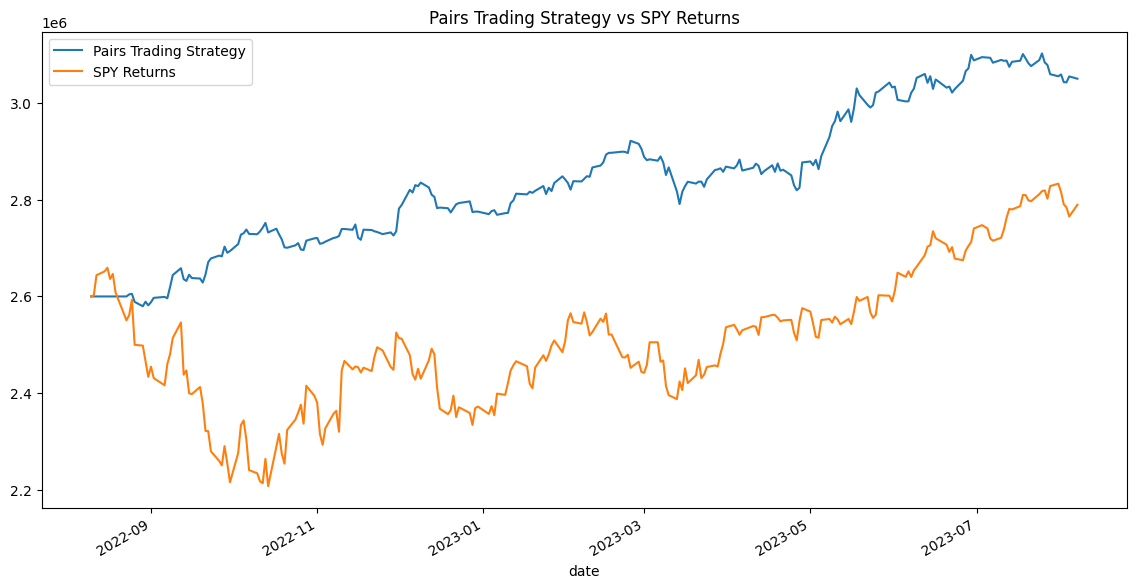

{'Alpha': 0.0006267082913782839,
 'Beta': 0.07728324898978171,
 'Sharpe Ratio': -1.9363258313418925,
 'Total Return': 0.17343951882127476}

In [125]:
# this is to run one time. 
dfs = []  # List to store individual pair dataframes

for pair in cointegrated_pairs:
    stock1, stock2, _ = pair
    
    df_combined = process_pair(df, stock1, stock2, lookback=10, threshold=1.5, trade_percentage=.6, max_multiplier = 2.5, stop_loss_percentage=0.04, take_profit_percentage = 0.05)
    df_combined['pair'] = f"{stock1}-{stock2}"  # Add an additional column to identify the pair
    dfs.append(df_combined)

master_df = pd.concat(dfs)

daily_df = master_df.groupby(master_df.index).agg({
    'portfolio_value': 'sum',
    'total_cash': 'sum',
    'SPY_returns': 'first'
})

initial_investment = daily_df['portfolio_value'].iloc[0]
daily_df['SPY_cumulative_returns'] = (1 + daily_df['SPY_returns']).cumprod()
daily_df['SPY_portfolio_value'] = initial_investment * daily_df['SPY_cumulative_returns']

def evaluate_aggregated_df(df):
    #expected that df is the daily_df
    # Total return
    final_portfolio_value = df['portfolio_value'].iloc[-1]
    initial_investment = df['portfolio_value'].iloc[0]
    total_return = (final_portfolio_value - initial_investment) / initial_investment

    # Prepare data for regression
    X = df['SPY_returns']
    X = sm.add_constant(X)  # Adds a constant (intercept) to the model
    y = df['portfolio_value'].pct_change().fillna(0)

    # Regression model
    model = sm.OLS(y, X).fit()

    alpha = model.params[0]
    beta = model.params[1]
    
    # 5. Calculate Sharpe Ratio:
    risk_free_rate = 0.01  # Approximated risk-free rate, adjust as needed
    strategy_excess_return = df['portfolio_value'].pct_change().mean() - risk_free_rate
    strategy_std = df['portfolio_value'].pct_change().std()
    sharpe_ratio = strategy_excess_return / strategy_std

    return {
        "Alpha": alpha,
        "Beta": beta,
        "Sharpe Ratio": sharpe_ratio,
        "Total Return": total_return
    }

def plot_aggregated(df):
    plt.figure(figsize=(14,7))
    df['portfolio_value'].plot(label='Pairs Trading Strategy')
    df['SPY_portfolio_value'].plot(label='SPY Returns')
    plt.legend()
    plt.title('Pairs Trading Strategy vs SPY Returns')
    plt.show()
    
plot_aggregated(daily_df)
evaluate_aggregated_df(daily_df)

In [121]:
# Grid Search

from itertools import product

# Define your parameter grid.
param_grid = {
    'lookback': [10, 20, 30, 40],
    'threshold': [0.5, 1, 1.5],
    'trade_percentage': [0.40, 0.50, 0.60],
    'max_multiplier': [1.5, 2.0, 2.5],
    'stop_loss_percentage': [0.02, 0.03, 0.04],
    'take_profit_percentage': [0.04, 0.05, 0.06]
}

all_names = sorted(param_grid)
combinations = product(*(param_grid[name] for name in all_names))
column_order = ["Alpha", "Beta", "Sharpe Ratio", "Total Return"] + all_names
df_results = pd.DataFrame(columns=column_order)

# Grid search loop
for values in combinations:
    params = dict(zip(all_names, values))

    dfs = []
    for pair in cointegrated_pairs:
        stock1, stock2, _ = pair
        df_combined = process_pair(df, stock1, stock2, **params)
        df_combined['pair'] = f"{stock1}-{stock2}"
        dfs.append(df_combined)

    master_df = pd.concat(dfs)
    daily_df = master_df.groupby(master_df.index).agg({
        'portfolio_value': 'sum',
        'total_cash': 'sum',
        'SPY_returns': 'first'
    })

    initial_investment = daily_df['portfolio_value'].iloc[0]
    daily_df['SPY_cumulative_returns'] = (1 + daily_df['SPY_returns']).cumprod()
    daily_df['SPY_portfolio_value'] = initial_investment * daily_df['SPY_cumulative_returns']

    performance = evaluate_aggregated_df(daily_df)
    
    # Store results
    for param_name, param_value in params.items():
        performance[param_name] = param_value

    df_results.loc[len(df_results)] = performance  # Add performance to the results dataframe

# Sort by alpha for easier review
df_results = df_results.sort_values(by="Alpha", ascending=False).reset_index(drop=True)


In [124]:
df_results.to_csv("results.csv")

In [128]:
# Genetic Search

import random
from deap import base, creator, tools, algorithms

# Define your parameter grid
param_grid = {
    'lookback': [10, 20, 30, 40],
    'threshold': [0.5, 1, 1.5],
    'trade_percentage': [0.40, 0.50, 0.60],
    'max_multiplier': [1.5, 2.0, 2.5],
    'stop_loss_percentage': [0.02, 0.03, 0.04],
    'take_profit_percentage': [0.04, 0.05, 0.06]
}

all_names = sorted(param_grid)

# Define the Genetic Algorithm
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_int", random.randint, 0, 1)  # Generate 0 or 1 to index values from param_grid
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, len(all_names))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def map_params(ind):
    """Map individual's genes to the actual parameter values."""
    mapped_params = []
    for i, name in enumerate(all_names):
        param_values = param_grid[name]
        mapped_params.append(param_values[int(ind[i]) % len(param_values)])
    return mapped_params

def objective(ind):
    params = map_params(ind)
    params_dict = dict(zip(all_names, params))
    
    dfs = []
    for pair in cointegrated_pairs:
        stock1, stock2, _ = pair
        df_combined = process_pair(df, stock1, stock2, **params_dict)
        df_combined['pair'] = f"{stock1}-{stock2}"
        dfs.append(df_combined)

    master_df = pd.concat(dfs)
    daily_df = master_df.groupby(master_df.index).agg({
        'portfolio_value': 'sum',
        'total_cash': 'sum',
        'SPY_returns': 'first'
    })

    initial_investment = daily_df['portfolio_value'].iloc[0]
    daily_df['SPY_cumulative_returns'] = (1 + daily_df['SPY_returns']).cumprod()
    daily_df['SPY_portfolio_value'] = initial_investment * daily_df['SPY_cumulative_returns']

    performance = evaluate_aggregated_df(daily_df)
    return performance["Alpha"],

toolbox.register("evaluate", objective)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# Initialize and run the genetic algorithm
population = toolbox.population(n=100)
ngen = 10  # for demonstration, increase as needed
cxpb = 0.7
mutpb = 0.2

algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen)


/home/myuser/.local/lib/python3.8/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/myuser/.local/lib/python3.8/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	100   
1  	90    
2  	73    
3  	79    
4  	84    
5  	72    
6  	86    
7  	77    
8  	75    
9  	75    
10 	80    


([[1, 1, 1, 0, 0, 0],
  [1, 1, 1, 0, 1, 0],
  [1, 1, 1, 0, 1, 0],
  [1, 1, 1, 0, 0, 0],
  [1, 1, 1, 0, 0, 0],
  [1, 1, 1, 0, 0, 0],
  [1, 1, 1, 0, 0, 0],
  [1, 1, 1, 0, 1, 0],
  [1, 1, 1, 0, 0, 0],
  [1, 1, 1, 0, 1, 0],
  [1, 1, 1, 0, 0, 0],
  [1, 1, 1, 0, 1, 0],
  [1, 1, 1, 0, 1, 0],
  [1, 1, 1, 0, 1, 0],
  [1, 1, 1, 0, 1, 0],
  [1, 1, 1, 0, 0, 0],
  [1, 1, 1, 0, 0, 0],
  [1, 1, 1, 0, 0, 0],
  [1, 1, 1, 0, 1, 0],
  [1, 1, 1, 0, 1, 0],
  [1, 1, 1, 0, 0, 0],
  [1, 1, 1, 0, 1, 1],
  [1, 1, 1, 0, 1, 0],
  [1, 1, 1, 0, 1, 0],
  [1, 1, 1, 1, 1, 0],
  [1, 1, 1, 0, 0, 0],
  [1, 1, 1, 0, 0, 0],
  [1, 1, 1, 0, 1, 0],
  [1, 1, 1, 0, 0, 0],
  [1, 1, 1, 0, 0, 0],
  [0, 1, 1, 1, 1, 0],
  [1, 1, 1, 0, 0, 0],
  [1, 1, 1, 0, 0, 0],
  [1, 1, 1, 0, 1, 0],
  [1, 1, 1, 0, 0, 0],
  [1, 1, 1, 0, 1, 0],
  [1, 1, 1, 0, 0, 0],
  [1, 1, 1, 0, 1, 0],
  [1, 1, 1, 0, 0, 0],
  [1, 1, 1, 0, 0, 0],
  [1, 1, 1, 0, 0, 0],
  [1, 1, 1, 0, 1, 0],
  [1, 1, 1, 0, 0, 0],
  [1, 1, 1, 0, 1, 0],
  [1, 1, 1, 0, 0, 0],
  [1, 1, 1

In [129]:
best_ind = tools.selBest(population, 1)[0]

In [130]:
best_params_values = map_params(best_ind)
best_params_dict = dict(zip(all_names, best_params_values))

In [131]:
print("Best Parameters:", best_params_dict)

Best Parameters: {'lookback': 20, 'max_multiplier': 2.0, 'stop_loss_percentage': 0.03, 'take_profit_percentage': 0.04, 'threshold': 0.5, 'trade_percentage': 0.4}


In [ ]:
# code runs but sharpe is not calculated properly

initial_investment=100000

def main_function(lookback, thresh, exit_thresh, num_pairs, initial_investment=100000):

    class MeanReversion(bt.Strategy):
        params = {
            'lookback': lookback,
            'thresh': thresh,
            'exit_thresh': exit_thresh,
            'pair_index': 0 

        }

        def __init__(self):
            self.data0 = self.getdatabyname(f"{self.params.pair_index}_0")
            self.data1 = self.getdatabyname(f"{self.params.pair_index}_1")

            self.spread = self.data0.close / self.data1.close
            self.mean = bt.indicators.SimpleMovingAverage(self.spread, period=self.params.lookback)
            self.std = bt.indicators.StdDev(self.spread, period=self.params.lookback)    

        def next(self):
            if self.getposition(self.data0).size:
                if abs(self.spread[0] - self.mean[0]) < self.params.exit_thresh * self.std[0]:
                    self.close(data=self.data0)
                    self.close(data=self.data1)
            elif self.spread[0] > self.mean[0] + self.params.thresh * self.std[0]:
                self.sell(data=self.data0, size=1000/self.data0.open[0])
                self.buy(data=self.data1, size=1000/self.data1.open[0])
            elif self.spread[0] < self.mean[0] - self.params.thresh * self.std[0]:
                self.buy(data=self.data0, size=1000/self.data0.open[0])
                self.sell(data=self.data1, size=1000/self.data1.open[0])    
        
    def recursive_merge_dicts(dict1, dict2):
        """Merge two dictionaries recursively."""
        for key, value in dict2.items():
            if key in dict1:
                if isinstance(value, dict) and isinstance(dict1[key], dict):
                    recursive_merge_dicts(dict1[key], value)
                else:
                    dict1[key] += value
            else:
                dict1[key] = value
        return dict1
        

    def run_cumulative_backtest(pairs, starting_cash):
        cerebro = bt.Cerebro()
        for idx, pair in enumerate(pairs):
            data1 = bt.feeds.PandasData(dataname=df[df['ticker'] == pair[0]], plot=False, name=f"{idx}_0")
            data2 = bt.feeds.PandasData(dataname=df[df['ticker'] == pair[1]], plot=False, name=f"{idx}_1")

            cerebro.adddata(data1)
            cerebro.adddata(data2)
            cerebro.addstrategy(MeanReversion, pair_index=idx)

        cerebro.broker.setcash(starting_cash)
        cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='mysharpe')
        cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='mytrades')

        results = cerebro.run()

        # Collate the results
        final_value = cerebro.broker.getvalue()
        sharpe_ratio = sum(r.analyzers.mysharpe.get_analysis()['sharperatio'] for r in results) / len(results)
        trade_analysis = {}
        for r in results:
            trade_analysis = recursive_merge_dicts(trade_analysis, r.analyzers.mytrades.get_analysis())

        return {
            "final_value": final_value,
            "sharpe_ratio": sharpe_ratio,
            "trade_analysis": trade_analysis
        }


    result = run_cumulative_backtest(cointegrated_pairs[0:num_pairs], initial_investment)
    return result

def display_result(result, initial_investment):
    print("="*40)
    print("Backtest Results")
    print("="*40)
    print(f"Final Value: ${result['final_value']:.2f}")
    
    total_return = ((result['final_value'] / initial_investment) - 1) * 100
    print(f"Total Return: {total_return:.2f}%")
    print(f"Sharpe Ratio: {result['sharpe_ratio']:.2f}")
    print("-"*40)

    trades = result['trade_analysis']

    print("Trade Analysis:")
    print("-"*40)
    print(f"Total Trades: {trades['total']['total']}")
    print(f"Open Trades: {trades['total']['open']}")
    print(f"Closed Trades: {trades['total']['closed']}")
    print(f"Longest Winning Streak: {trades['streak']['won']['longest']}")
    print(f"Longest Losing Streak: {trades['streak']['lost']['longest']}")
    print("-"*40)

    print("Profit/Loss Analysis:")
    print("-"*40)
    print(f"Total Gross Profit/Loss: ${trades['pnl']['gross']['total']:.2f}")
    print(f"Total Net Profit/Loss: ${trades['pnl']['net']['total']:.2f}")
    print(f"Total Winning Trades Value: ${trades['won']['pnl']['total']:.2f}")
    print(f"Total Losing Trades Value: ${trades['lost']['pnl']['total']:.2f}")
    print("-"*40)

    print("Trade Length Analysis:")
    print("-"*40)
    print(f"Total Trade Length: {trades['len']['total']}")
    print(f"Average Trade Length: {trades['len']['average']:.2f}")
    print(f"Max Trade Length: {trades['len']['max']}")
    print(f"Min Trade Length: {trades['len']['min']}")
    print("-"*40)

    print("Trade Types Analysis:")
    print("-"*40)
    print(f"Total Long Trades: {trades['long']['total']}")
    print(f"Total Short Trades: {trades['short']['total']}")
    print(f"Winning Long Trades: {trades['long']['won']}")
    print(f"Losing Long Trades: {trades['long']['lost']}")
    print(f"Winning Short Trades: {trades['short']['won']}")
    print(f"Losing Short Trades: {trades['short']['lost']}")

    print("="*40)
    
# Define parameter grid
lookback_values = [10, 20, 30, 40, 50]
thresh_values = [1, 1.5, 2, 2.5]
exit_thresh_values = [0.5, 1, 1.5, 2]
num_pairs_values = [10, 20, 25]


# Store best values
best_sharpe = float('-inf')
best_params = {}
results_list = []

# Grid search
for lookback in lookback_values:
    for thresh in thresh_values:
        for exit_thresh in exit_thresh_values:
            for num_pairs in num_pairs_values:
                
                # Run main_function with the current parameters
                result = main_function(lookback, thresh, exit_thresh, num_pairs)
                
                # Store the results
                results_list.append({
                    'lookback': lookback,
                    'thresh': thresh,
                    'exit_thresh': exit_thresh,
                    'num_pairs': num_pairs,
                    'sharpe_ratio': result['sharpe_ratio'],
                    'full_result': result   # Storing the entire result

                })
                
                # Update best parameters if current run is better
                if result['sharpe_ratio'] > best_sharpe:
                    best_sharpe = result['sharpe_ratio']
                    best_params = {
                        'lookback': lookback,
                        'thresh': thresh,
                        'exit_thresh': exit_thresh,
                        'num_pairs': num_pairs
                    }
                    
df_results = pd.DataFrame(results_list)
df_results = df_results.sort_values(by='sharpe_ratio', ascending=False)
print("Best Parameters:", best_params)


for _, row in df_results.head(5).iterrows():
    print("\n==============================")
    print(f"Parameters: Lookback={row['lookback']}, Thresh={row['thresh']}, Exit Thresh={row['exit_thresh']}, Num Pairs={row['num_pairs']}")
    print("==============================")
    display_result(row['full_result'], initial_investment)